# Verify the conservation of tracer mass in different runs

In [5]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

## read tracers

In [6]:
[grid_l, ~, ~] = read_grid_MOM('/glade/work/yueyanglu/MOM6_exp/mom_lowRES/'); 
nk = 3;
grid_al = {grid_l, grid_l, grid_l, grid_l, grid_l, grid_l, grid_l, grid_l};
fldnm = 'tr1';

yr_s = 21;
[day_s, day_e, dt] = deal(1.0, 730.0, 5);  % 730 570
t_al = day_s:dt:day_e;
nt_al = length(t_al);


E_al = { [workdir '/MOM6_OUT/tr_off_64_180d/sols_pt/tr_noforc_ptrel/'], ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_pt/tr_noforc_ptrel_paramka400Chidotn_SIGNFIT_usefitchin/'] ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_pt/tr_noforc_ptrel_paramka400Chidotn_chinclosure1d_alpha/'] ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_pt/tr_forcprog_addrel10d_ptrel/'] ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_cfc11/tr_noforc/'], ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_cfc11/tr_noforc_paramka400Chidotn_SIGNFIT_usefitchin/'] ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_cfc11/tr_noforc_paramka400Chidotn_chinclosure1d_alpha/'] ...
         [workdir '/MOM6_OUT/tr_off_64_180d/sols_cfc11/tr_forcprog_addrel10d_norel/']};
initfnm_al = {[workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_init_pt_cs.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_init_pt_cs.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_init_pt_cs.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_init_pt_cs.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_CFC11_64.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_CFC11_64.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_CFC11_64.nc'],...
            [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_CFC11_64.nc']};   

hdir_al = {[workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/'],...
           [workdir '/MOM6_OUT/forc_uvh_64/sol_h_180d/']};

ncel = numel(E_al);

%---- initials
[cinit_al, cminit_al] = deal( cell(1,ncel) ); 
% ---- read init dist
for icel = 1:ncel
    cinit_al{icel} = ncread(initfnm_al{icel},fldnm);
    h_initfnm = [hdir_al{icel} 'h_snap__0021_001_00.nc'];
    hinit = ncread(h_initfnm, 'h');
    cminit_al{icel} = cinit_al{icel} .* hinit .* grid_al{icel}.Ah;
end

%-----------------------
[mass_h_al, mass_ch_al, c_al, ca_al, cm_al, cmm_al, vol_al] = deal(cell(1,ncel)); 
for it = 1:nt_al
   
    % current time
    t1 = t_al(it);
    [yrstr, dystr, hrstr] = get_timestr(t1, yr_s); % for k and tracer
    
    % read all runs
    for icel = 1:ncel
        c_fnm = [E_al{icel} 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
        h_fnm = [hdir_al{icel} 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
        % fnm
        c3d = ncread(c_fnm,fldnm);
        h3d = ncread(h_fnm,'h');
        
        % [c] and [c*Vol]
        vol_al{icel}(:,:,:,it) = h3d.* grid_al{icel}.Ah; %[m3]
        cm_al{icel}(:,:,:,it) = c3d .*h3d.*grid_al{icel}.Ah;
        %
        mass_h_al{icel}(:,it) = sum( h3d.* grid_al{icel}.Ah, [1 2] );
        mass_ch_al{icel}(:,it) = sum( c3d.*h3d .* grid_al{icel}.Ah, [1 2] );
    end
end

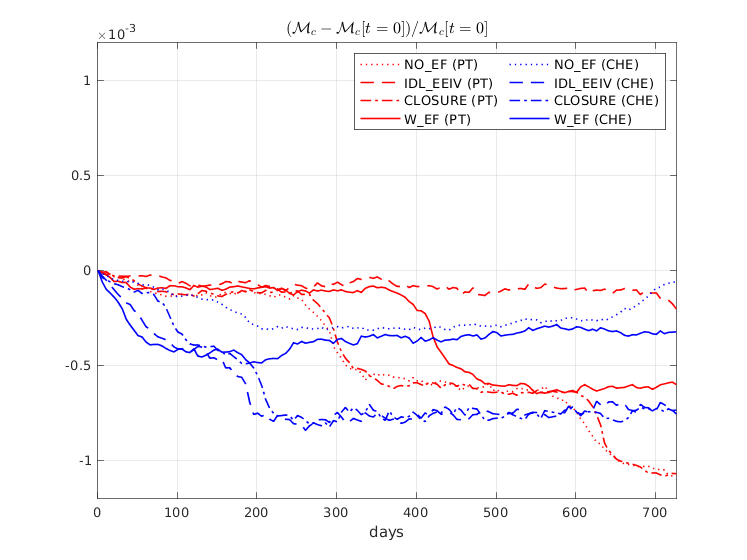

In [7]:
styles = {'r:','r--','r-.','r-', 'b:','b--','b-.','b-'}; 

f_plt_al = mass_ch_al;
titles = {'NO\_EF (PT)', 'IDL\_EEIV (PT)', 'CLOSURE (PT)', 'W\_EF (PT)', ...
          'NO\_EF (CHE)', 'IDL\_EEIV (CHE)', 'CLOSURE (CHE)', 'W\_EF (CHE)'};

font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);
for ik = 1:1
    subplot(1,1,ik)
    for icel = 1:ncel
        f1d = f_plt_al{icel}(ik,:);
        fplt = (f1d - f1d(1)) ./ f1d(1);
        % fplt = f1d;
        plot(t_al,fplt,styles{icel},'linewidth',1.2); 
        hold on
    end
end
grid on
set(gca,'XLim',[0 t_al(end)],'YLim',[-1.2e-3 1.2e-3])
legend(titles,'location','northeast','NumColumns',2,'fontsize',10)
title('$(\mathcal{M}_c - \mathcal{M}_c[t=0])/\mathcal{M}_c[t=0]$','interpreter','latex','fontsize',12)
xlabel('days')

set(gcf,'PaperPositionMode','auto'); 

% ---
fignm = [homedir '/work_MOM/figures/fig_appxE_conserve'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')